In [1]:
import urllib.request

# Define the download URL and target path
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
target_path = "flower_photos.tgz"

# Download the dataset
urllib.request.urlretrieve(dataset_url, target_path)

print("Dataset downloaded successfully!")


Dataset downloaded successfully!


In [2]:
import tarfile

# Extract the downloaded file
with tarfile.open(target_path) as tar:
    tar.extractall()

print("Dataset extracted successfully!")

Dataset extracted successfully!


In [3]:
import os

# Define the main data directory
data_dir = "flower_photos"
print(data_dir)

flower_photos


In [4]:
# Count images and print size
total_images = 0
for root, _, files in os.walk(data_dir):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png')):  # Adjust for your image formats
            total_images += 1
            image_path = os.path.join(root, file)

print("Total images downloaded:", total_images)


Total images downloaded: 3670


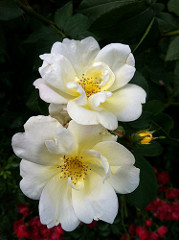

In [5]:
import pathlib
from PIL import Image

roses_path = pathlib.Path(data_dir) / "roses"  # Ensure correct path using pathlib
roses_imgs = list(roses_path.glob('*.jpg'))  # Adjust file extension if needed

Image.open(str(roses_imgs[0]))

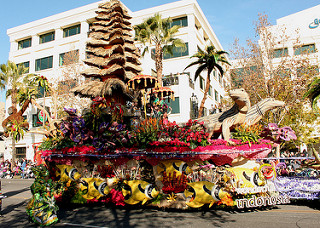

In [6]:
Image.open(str(roses_imgs[7]))

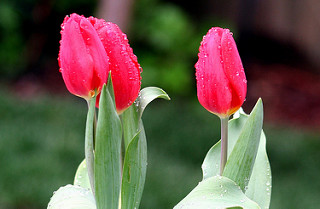

In [7]:
tulips_path = pathlib.Path(data_dir) / "tulips"  # Ensure correct path using pathlib
tulips_imgs = list(tulips_path.glob('*.jpg'))  # Adjust file extension if needed

Image.open(str(tulips_imgs[0]))

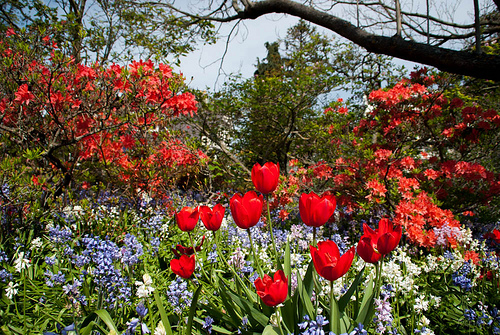

In [8]:
Image.open(str(tulips_imgs[5]))

In [9]:
batch_size = 32

In [11]:
from torchvision import datasets, transforms

# 1. Load the dataset
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #Rescale
])

In [12]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

dataset = ImageFolder(data_dir, transform = data_transform)
train_size = int(0.8 * len(dataset))  # Calculate 80% of dataset size
val_size = len(dataset) - train_size  # Calculate 20% of dataset size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [13]:
print(len(train_dataset))

2936


In [14]:
print(len(val_dataset))

734


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [15]:
class_names = dataset.classes
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=32)
val_dataloader = DataLoader(val_dataset, batch_size=32)

## Visualize the data

Here are the first 9 images from the training dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9124069..2.3262744].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.2489083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3235295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.2885156].

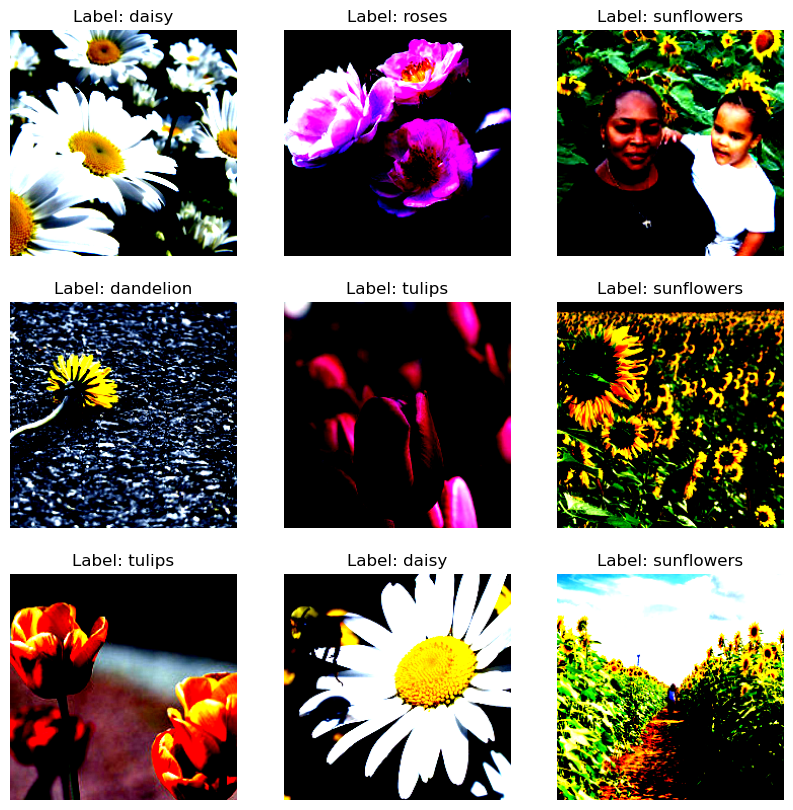

In [17]:
import torch
import torchvision
import matplotlib.pyplot as plt

# Assuming train_dl is your PyTorch DataLoader
data_iter = iter(train_dataloader)

# Fetch the first batch of data
images, labels = next(data_iter)

# Plot the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    image = images[i].permute(1, 2, 0).numpy()  # Convert tensor to numpy array
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Label: {class_names[labels[i].item()]}")
    plt.axis("off")

plt.show()


In [18]:
for image_batch, labels_batch in train_dataloader:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

torch.Size([32, 3, 224, 224])
torch.Size([32])


The image_batch is a torch tensor of the shape (32, 3, 224, 224). This is a batch of 32 images of shape 224x224x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

In [19]:
print(len(train_dataloader.dataset))
print(train_dataloader.dataset[0][0].shape)
print(train_dataloader.dataset[1][0].shape)

2936
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


asz3ecdfgrvx

# Build the model

In [21]:
import torch
import torch.nn as nn

class CustomModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomModel, self).__init__()
        self.rescale = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=1),  # Rescaling layer, 1x1 conv
            nn.BatchNorm2d(3),  # Batch normalization to maintain scale
            nn.ReLU(inplace=True)
        )
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(224 * 224 * 32, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.rescale(x)
        x = self.conv1(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.pool3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.fc2(x)
        return x

# Instantiate the model
num_classes = 5
model = CustomModel(num_classes)

# Print the model architecture
print(model)


CustomModel(
  (rescale): Sequential(
    (0): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1605632, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)


In [22]:
import torch
import torch.nn as nn

class CNNModel(nn.Module):
    def __init__(self, num_classes, img_height, img_width):
        super(CNNModel, self).__init__()
        self.rescaling = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=1),
            nn.BatchNorm2d(3),
            nn.ReLU(inplace=True)
        )
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * (img_height // 8) * (img_width // 8), 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.rescaling(x)
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = self.flatten(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define input dimensions
img_height, img_width = 224, 224
# Define the number of classes
num_classes = 5

# Instantiate the model
model = CNNModel(num_classes, img_height, img_width)


Compile the model: choose the optimizers. Adam optimizer and losses.SparseCategoricalCrossentropy loss function. To view training and validation accuracy for each training epoch, pass the metrics argument.



In [23]:
import torch.optim as optim
import torch.nn.functional as F

# Define the optimizer
optimizer = optim.Adam(model.parameters())

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the metrics (accuracy)
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Define the training loop
def train_model(model, train_dl, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # Set the model to train mode
        train_loss = 0.0
        train_acc = 0.0

        for images, labels in train_dl:
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            # Compute training accuracy
            acc = accuracy(outputs, labels)
            train_acc += acc.item() * images.size(0)

            # Track training loss
            train_loss += loss.item() * images.size(0)

        # Print training statistics
        epoch_loss = train_loss / len(train_dl.dataset)
        epoch_acc = train_acc / len(train_dl.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

# Train the model
num_epochs = 5  # Choose the number of epochs
train_model(model, train_dataloader, criterion, optimizer, num_epochs)

Epoch 1/5, Loss: 1.3053, Accuracy: 0.4544
Epoch 2/5, Loss: 1.0062, Accuracy: 0.6001
Epoch 3/5, Loss: 0.8336, Accuracy: 0.6890
Epoch 4/5, Loss: 0.6291, Accuracy: 0.7653
Epoch 5/5, Loss: 0.4556, Accuracy: 0.8324


Training loop with Data Augmentation layers to avoid overfitting

In [24]:
import torch.optim as optim
import torch.nn.functional as F

# Define the optimizer
optimizer = optim.Adam(model.parameters())

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the metrics (accuracy)
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Define the training loop
def train_model(model, train_dl, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # Set the model to train mode
        train_loss = 0.0
        train_acc = 0.0

        for images, labels in train_dl:
            data_augmented_inputs = torch.stack([transforms.RandomHorizontalFlip()(img) for img in images])
            data_augmented_inputs = torch.stack([transforms.RandomRotation(degrees=10)(img) for img in data_augmented_inputs])
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            # Compute training accuracy
            acc = accuracy(outputs, labels)
            train_acc += acc.item() * images.size(0)

            # Track training loss
            train_loss += loss.item() * images.size(0)

        # Print training statistics
        epoch_loss = train_loss / len(train_dl.dataset)
        epoch_acc = train_acc / len(train_dl.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

# Train the model
num_epochs = 3  # Choose the number of epochs
train_model(model, train_dataloader, criterion, optimizer, num_epochs)

Epoch 1/3, Loss: 0.2588, Accuracy: 0.9152
Epoch 2/3, Loss: 0.1131, Accuracy: 0.9646
Epoch 3/3, Loss: 0.0847, Accuracy: 0.9768


In [31]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import requests
from io import BytesIO
from torch import argmax

img_height, img_width = 224, 224
# Define the URL of the image
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"

# Download the image and convert it to a PyTorch tensor
response = requests.get(sunflower_url)
img = Image.open(BytesIO(response.content)).convert('RGB')
img = img.resize((img_width, img_height))  # Resize the image to match the model's input size
img_tensor = transforms.ToTensor()(img)
img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension

# Move the tensor to the appropriate device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_tensor = img_tensor.to(device)


In [39]:
# Make predictions
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(img_tensor)
    probabilities = torch.softmax(outputs, dim=1)

# Convert tensor to numpy array
predicted_class = class_names[argmax(probabilities)]

# Print the predicted class and confidence
predicted_class = class_names[torch.argmax(probabilities)]
confidence = torch.max(probabilities).item()
print(f"This image most likely belongs to {predicted_class} with a {confidence*100:.2f}% confidence.")


This image most likely belongs to dandelion with a 57.12% confidence.


In [40]:
# Load and preprocess the unseen image
image_path = '/content/test_img.jpeg'  # Replace with the path to your image
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

In [46]:
# Perform inference
with torch.no_grad():
    output = model(input_batch)

# Get the predicted class
_, predicted_class = output.max(1)

# Map the predicted class to the class name
#class_names = ['daisy', 'dandelion']  # Make sure these class names match your training data
predicted_class_name = class_names[predicted_class.item()]
probabilities = torch.softmax(outputs, dim=1)
confidence = torch.max(probabilities).item()
print(f"This image most likely belongs to {predicted_class_name} with a {confidence*100:.2f}% confidence.")

This image most likely belongs to sunflowers with a 57.12% confidence.
The predicted class is: sunflowers


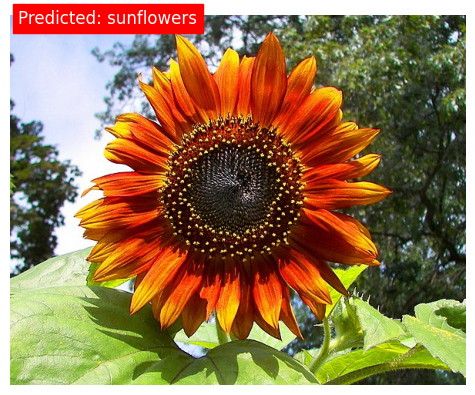

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='red')
plt.show()